## Harjoitustyö



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
!pip install scrapy

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached Scrapy-2.5.0-py2.py3-none-any.whl (254 kB)
Processing /root/.cache/pip/wheels/dc/d0/bf/0cc715c01fce0bace63b46283acf5cc630d5e5dbb4602c54e5/PyDispatcher-2.0.5-py3-none-any.whl
  Using cached zope.interface-5.4.0-cp37-cp37m-manylinux2010_x86_64.whl (251 kB)
Processing /root/.cache/pip/wheels/ca/44/01/3592ccfbcfaee4ab297c4097e6e9dbe1c7697e3531a39877ab/Protego-0.1.16-py3-none-any.whl
  Using cached w3lib-1.22.0-py2.py3-none-any.whl (20 kB)
  Using cached service_identity-18.1.0-py2.py3-none-any.whl (11 kB)
  Using cached itemadapter-0.2.0-py3-none-any.whl (9.3 kB)
  Using cac

In [22]:
!scrapy genspider etuovi_scraper etuovi.com

Created spider 'etuovi_scraper' using template 'basic' 


In [23]:
## lopullinen raapija

import scrapy
# raapija, joka kerää etuovi.com:sta ilmoituksien tiedoista
# asuntotyypin, osoitteen, hinnan, valmistuvuoden ja pinta-alan.
# (Kyseessä Tampereen omakotitalot)
class EtuoviScraperSpider(scrapy.Spider):
    name = 'etuovi_scraper'
    allowed_domains = ['etuovi.com']
    # assing a page url below
    start_urls = \
    ['https://www.etuovi.com/myytavat-asunnot?haku=M1644983732&sivu=0']

  # Funkito parse(self, response) käy läpi aloitusosoitteesta eteenpäin
  # sivuja, joilta dataa kerätään. Parse kutsuu parse_page-funktiota, jossa
  # on määritelty varsinainen kerättävä tieto.
  # max 5 sivua tässä esimerkissä
    def parse(self, response):
        for i in range(1, 21):
            url=response.request.url[:-1]+str(i)
            yield scrapy.Request(url, callback=self.parse_page)
        
    
    def parse_page(self, response):
        description_texts = response.css(\
          '[class="flexboxgrid__col-xs-12__1I1LS"] *::text').extract()
        size_text = response.css(\
          '[class="flexboxgrid__col-xs__26GXk flexboxgrid__col-md-4__2DYW-"] > span::text').extract()
        year_text = response.css(\
          '[class="flexboxgrid__col-xs-3__3Kf8r flexboxgrid__col-md-4__2DYW-"] > span::text'\
          ).extract()
        price_text = response.css(\
          '[class="flexboxgrid__col-xs-4__p2Lev flexboxgrid__col-md-4__2DYW-"] > span::text'\
          ).extract()

        for i in range(len(price_text)):
            yield {
                'house_type' : description_texts[2*i],
                'address': description_texts[2*i+1],
                'price': price_text[i],
                'year': year_text[i],
                'size': size_text[i]
            }

In [24]:
!scrapy runspider etuovi_scraper.py -o out.json

2021-04-23 15:18:27 [scrapy.utils.log] INFO: Scrapy 2.5.0 started (bot: scrapybot)
2021-04-23 15:18:27 [scrapy.utils.log] INFO: Versions: lxml 4.6.3.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 21.2.0, Python 3.7.10 (default, Feb 26 2021, 18:47:35) - [GCC 7.3.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1k  25 Mar 2021), cryptography 3.4.7, Platform Linux-4.14.225-169.362.amzn2.x86_64-x86_64-with-debian-10.6
2021-04-23 15:18:27 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2021-04-23 15:18:27 [scrapy.crawler] INFO: Overridden settings:
{'SPIDER_LOADER_WARN_ONLY': True}
2021-04-23 15:18:27 [scrapy.extensions.telnet] INFO: Telnet Password: c610491975b07e21
2021-04-23 15:18:27 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogStats']
202

In [29]:
!git commit -m "data collection modified, data cleaning and visualization added"

[master 78d89c4] data collection modified, data cleaning and visualization added
 1 file changed, 2072 insertions(+), 135 deletions(-)


In [28]:
!git add 'joda_ht.ipynb'

In [2]:
!git config --global user.email "sara.paukkeri@hotmail.com"

## Datan siivoaminen ja piirteiden  muokkaus

In [2]:
import json

In [3]:
# read out.json file to d
d = open('out.json')
#d = open('out2.json') #whole dataset
data = json.load(d)
d.close()
data[0:1]

[{'house_type': 'Omakotitalo | 4 h, k, ph, s, wc, at',
  'address': 'Unikeonkatu 6, Yli-Maaria, Turku',
  'price': '115\xa0000\xa0€',
  'year': '1968',
  'size': '99,5 / 124 m²'}]

In [4]:
# convert array to dataframe
df = pd.DataFrame(data)
df.head()

,house_type,address,price,year,size
0,"Omakotitalo | 4 h, k, ph, s, wc, at","Unikeonkatu 6, Yli-Maaria, Turku",115 000 €,1968,"99,5 / 124 m²"
1,Omakotitalo | 3h + k + 2wc + ph + s,"Lähteeläntie 11, Jyskä, Jyväskylä",135 000 €,1950,-
2,"Omakotitalo | 3mh, oh, avok, kh, 2wc, kph, s, ...","Kaistisenkatu 23, Piispanristi, Turku",398 000 €,2007,181 / 222 m²
3,"Omakotitalo | 7 mh, oh, k, rt, askarteluh, pkh...","Koppalankaari 60, Palokka/Terttumäki, Jyväskylä",385 000 €,1948,200 / 267 m²
4,"Omakotitalo | 5h, k, kph, s, AT","Ukkoherrankuja 3, Yli-Ii, Oulu",395 000 €,1989,120 / 180 m²


In [5]:
# split column size to size and living_space and remove "m2" and spaces
# add rows with empty values(="-") to remove
remove=[]



living_space=[]
for i in range(0, df['size'].size):
  
    if "/" in df['size'][i]: 
        sizes = df.loc[i,'size'].split("/")
        df.loc[i,'size'] = sizes[1].replace(" ", "").replace("m\u00b2","").replace(",",".").replace("\xa0", "")
        living_space.append(sizes[0].replace(" ", "").replace(",",".").replace("\xa0", ""))
    elif df['size'][i] != "-": #  only one size available
        df.loc[i,'size'] = df.loc[i,'size'].replace(" ", "").replace("m\u00b2","").replace(",",".").replace("\xa0", "")
        living_space.append(df.loc[i,'size'])
    else: # size is "-" or
        living_space.append(0)
        remove.append(i)
        df.loc[i,'size']=None

#df=df.dropna()
  
df['living_space']=living_space

df['size'] = df['size'].astype(float)
df.living_space = df.living_space.astype(float)

In [6]:
# remove € from price and set datatype to int
for i in range(0, df['price'].size): #=0; i < df.price.length; i++):
    #df['price'][i]=price.replace("-","")
    if (df.loc[i,'price']=='-') and (i not in remove):
        remove.append(i)
        df.loc[i,'price']=None
    else: 
        df.loc[i,'price'] = df.loc[i,'price'].replace("\xa0", "").replace('€',"").replace(",",".")
        
#df=df.dropna()

df['price'] = df['price'].astype(float)

In [7]:
df.head()

,house_type,address,price,year,size,living_space
0,"Omakotitalo | 4 h, k, ph, s, wc, at","Unikeonkatu 6, Yli-Maaria, Turku",115000.0,1968,124.0,99.5
1,Omakotitalo | 3h + k + 2wc + ph + s,"Lähteeläntie 11, Jyskä, Jyväskylä",135000.0,1950,NaN,0.0
2,"Omakotitalo | 3mh, oh, avok, kh, 2wc, kph, s, ...","Kaistisenkatu 23, Piispanristi, Turku",398000.0,2007,222.0,181.0
3,"Omakotitalo | 7 mh, oh, k, rt, askarteluh, pkh...","Koppalankaari 60, Palokka/Terttumäki, Jyväskylä",385000.0,1948,267.0,200.0
4,"Omakotitalo | 5h, k, kph, s, AT","Ukkoherrankuja 3, Yli-Ii, Oulu",395000.0,1989,180.0,120.0


In [8]:
# Split address to address, region, area
area=[]
city=[]

for i in range(0, df['address'].size):
    add = df.loc[i,'address'].split(", ")
    df.loc[i,'address'] = add[0]
    if len(add) < 3:
        add2 = add[1].split(" ")
        if len(add2) < 2:
            city.append(add2[0])
            area.append(add2[0])
        else:
            city.append(add2[1])
            area.append(add2[0])
    else:
        area.append(add[1])
        city.append(add[2])
  
df['area']=area
df['city'] = city

In [9]:
rooms=[]

for i in range(0, df['house_type'].size):
    house = df.loc[i,'house_type'].split(" | ")
    if len(house) < 2: #only another information available
        df.loc[i,'house_type'] = house[0]
        rooms.append(house[0])
    else:
        df.loc[i,'house_type'] = house[0]
        rooms.append(house[1])
  
df['rooms']=rooms

In [10]:
for i in range(0, df.year.size):
    if df.loc[i,'year']=="-" and i not in remove:
        remove.append(i)

df = df.drop(remove)

df['year'] = df['year'].astype(int)

In [11]:
df.head()

,house_type,address,price,year,size,living_space,area,city,rooms
0,Omakotitalo,Unikeonkatu 6,115000.0,1968,124.0,99.5,Yli-Maaria,Turku,"4 h, k, ph, s, wc, at"
2,Omakotitalo,Kaistisenkatu 23,398000.0,2007,222.0,181.0,Piispanristi,Turku,"3mh, oh, avok, kh, 2wc, kph, s, khh, 4vh"
3,Omakotitalo,Koppalankaari 60,385000.0,1948,267.0,200.0,Palokka/Terttumäki,Jyväskylä,"7 mh, oh, k, rt, askarteluh, pkh / khh, ph, s,..."
4,Omakotitalo,Ukkoherrankuja 3,395000.0,1989,180.0,120.0,Yli-Ii,Oulu,"5h, k, kph, s, AT"
5,Omakotitalo,Seelannintie 26,129000.0,1993,200.0,143.0,Herukka,Oulu,Erilliset liike- / toimitilat + 5h + tupak + k...


Muokataan osoite koordinaateiksi

In [14]:
!pip install geopy

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [12]:
# edit the address to a format suitable for the coordinate change
df['geo_address'] = df["address"]+ ", " + df["city"] + ", Finland"

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = "joda ht")


In [13]:
df["loc"] = df["geo_address"].apply(geolocator.geocode)
# select koordinates from loc
df["point"] = df["loc"].apply(lambda loc: tuple(loc.point) if loc else None)
#split coordinates to latitude, longitude and altitude
df[['lat', 'lon', 'altitude']] = pd.DataFrame(df['point'].to_list(), index=df.index)

In [14]:
df.head()

,house_type,address,price,year,size,living_space,area,city,rooms,geo_address,loc,point,lat,lon,altitude
0,Omakotitalo,Unikeonkatu 6,115000.0,1968,124.0,99.5,Yli-Maaria,Turku,"4 h, k, ph, s, wc, at","Unikeonkatu 6, Turku, Finland","(6, Unikeonkatu, Yli-Maaria, Maaria-Paattinen,...","(60.5508547, 22.31609524144914, 0.0)",60.550855,22.316095,0.0
2,Omakotitalo,Kaistisenkatu 23,398000.0,2007,222.0,181.0,Piispanristi,Turku,"3mh, oh, avok, kh, 2wc, kph, s, khh, 4vh","Kaistisenkatu 23, Turku, Finland","(23, Kaistisenkatu, Kairiskulma, Piispanristi,...","(60.41573245, 22.32104154875271, 0.0)",60.415732,22.321042,0.0
3,Omakotitalo,Koppalankaari 60,385000.0,1948,267.0,200.0,Palokka/Terttumäki,Jyväskylä,"7 mh, oh, k, rt, askarteluh, pkh / khh, ph, s,...","Koppalankaari 60, Jyväskylä, Finland","(60, Koppalankaari, Terttumäki, Haukkamäki, Jy...","(62.297308349999994, 25.695705936147327, 0.0)",62.297308,25.695706,0.0
4,Omakotitalo,Ukkoherrankuja 3,395000.0,1989,180.0,120.0,Yli-Ii,Oulu,"5h, k, kph, s, AT","Ukkoherrankuja 3, Oulu, Finland","(Ukkoherrankuja, Yli-Ii, Oulu, Oulun seutukunt...","(65.3685837, 25.8408559, 0.0)",65.368584,25.840856,0.0
5,Omakotitalo,Seelannintie 26,129000.0,1993,200.0,143.0,Herukka,Oulu,Erilliset liike- / toimitilat + 5h + tupak + k...,"Seelannintie 26, Oulu, Finland","(Seelannintie, Herukka, Oulu, Oulun seutukunta...","(65.0988671, 25.416036, 0.0)",65.098867,25.416036,0.0


In [197]:
#df['loc'][0].address.split(",")[-2]

' 20400'

### Datan kuvaileminen

Text(0.5, 1.0, 'Living Space')

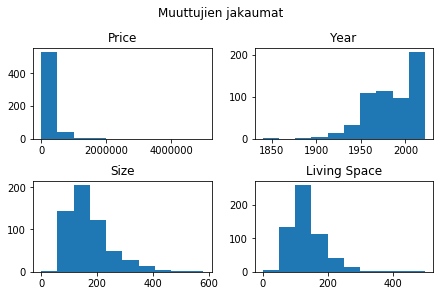

In [169]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 2)
fig.suptitle('Muuttujien jakaumat')

f_ax1 = fig.add_subplot(gs[0, 0])
f_ax1.hist(df['price'])
f_ax1.set_title('Price')
f_ax2 = fig.add_subplot(gs[0, 1])
f_ax2.hist(df['year'])
f_ax2.set_title('Year')
f_ax3 = fig.add_subplot(gs[1, 0])
f_ax3.hist(df['size'])
f_ax3.set_title('Size')
f_ax4 = fig.add_subplot(gs[1, 1])
f_ax4.hist(df['living_space'])
f_ax4.set_title('Living Space')

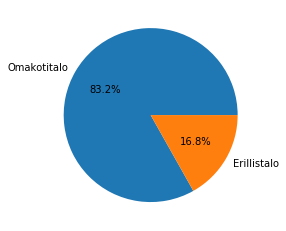

In [170]:
from collections import Counter

#type of houses in data
value = Counter(df['house_type']).values()
label = Counter(df['house_type']).keys()

plt.pie(value, labels = label, autopct='%1.1f%%')
plt.show()

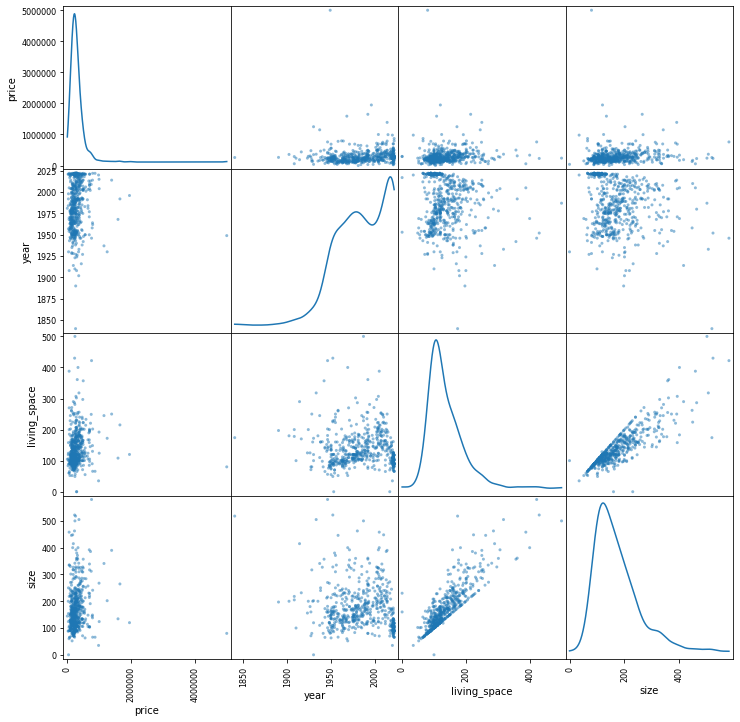

In [171]:
from pandas.plotting import scatter_matrix

# plot a scatter matrix to detect dependencies
df_int = df.loc[:,['price', 'year', 'living_space', 'size']]

scatter_matrix(df_int, figsize=(12,12), diagonal="kde");

In [67]:
!pip install folium

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 464 kB/s eta 0:00:011


In [172]:
import folium
from folium.plugins import MarkerCluster

#Define coordinates of where we want to center our map
center = [61.6027417, 23.8721711]

#Create the map
my_map = folium.Map(location = center, zoom_start = 5)

# Add addresses to the map
for index, row in df.iterrows():
    if row.point != None:
        text ="Price: " + str(row.price) + " €" + "\n Size: " + str(row['size']) + " m2 " + "Address: " + row.address
        folium.Marker([row.lat,row.lon], popup = text).add_to(my_map)

#Display the map
my_map

### Koneoppiminen

In [97]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import Ridge # Ridge algorithm
from sklearn.linear_model import Lasso # Lasso algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import r2_score # evaluation metric

import os

In [184]:
df.head()

,house_type,address,price,year,size,living_space,area,city,rooms,geo_address,loc,point,lat,lon,altitude
0,Omakotitalo,Unikeonkatu 6,115000.0,1968,124.0,99.5,Yli-Maaria,Turku,"4 h, k, ph, s, wc, at","Unikeonkatu 6, Turku, Finland","(6, Unikeonkatu, Yli-Maaria, Maaria-Paattinen,...","(60.5508547, 22.31609524144914, 0.0)",60.550855,22.316095,0.0
2,Omakotitalo,Kaistisenkatu 23,398000.0,2007,222.0,181.0,Piispanristi,Turku,"3mh, oh, avok, kh, 2wc, kph, s, khh, 4vh","Kaistisenkatu 23, Turku, Finland","(23, Kaistisenkatu, Kairiskulma, Piispanristi,...","(60.41573245, 22.32104154875271, 0.0)",60.415732,22.321042,0.0
3,Omakotitalo,Koppalankaari 60,385000.0,1948,267.0,200.0,Palokka/Terttumäki,Jyväskylä,"7 mh, oh, k, rt, askarteluh, pkh / khh, ph, s,...","Koppalankaari 60, Jyväskylä, Finland","(60, Koppalankaari, Terttumäki, Haukkamäki, Jy...","(62.297308349999994, 25.695705936147327, 0.0)",62.297308,25.695706,0.0
4,Omakotitalo,Ukkoherrankuja 3,395000.0,1989,180.0,120.0,Yli-Ii,Oulu,"5h, k, kph, s, AT","Ukkoherrankuja 3, Oulu, Finland","(Ukkoherrankuja, Yli-Ii, Oulu, Oulun seutukunt...","(65.3685837, 25.8408559, 0.0)",65.368584,25.840856,0.0
5,Omakotitalo,Seelannintie 26,129000.0,1993,200.0,143.0,Herukka,Oulu,Erilliset liike- / toimitilat + 5h + tupak + k...,"Seelannintie 26, Oulu, Finland","(Seelannintie, Herukka, Oulu, Oulun seutukunta...","(65.0988671, 25.416036, 0.0)",65.098867,25.416036,0.0


In [173]:
#select features
#0=house_type, 1=address 2=price, 3=year,
#4=size, 5=living_space, 6=area, 7=city

dfTrain = df.iloc[:,[0,2,3,5,7]]

In [174]:
dfTrain.head()

,house_type,price,year,living_space,city
0,Omakotitalo,115000.0,1968,99.5,Turku
2,Omakotitalo,398000.0,2007,181.0,Turku
3,Omakotitalo,385000.0,1948,200.0,Jyväskylä
4,Omakotitalo,395000.0,1989,120.0,Oulu
5,Omakotitalo,129000.0,1993,143.0,Oulu


In [175]:
# Converting house_type and city attributes to categorical values.
le = preprocessing.LabelEncoder()

arr = le.fit_transform(dfTrain.house_type)
dfTrain['house_type'] = arr

arr = le.fit_transform(dfTrain.city)
dfTrain['city'] = arr


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [176]:
dfTrain.head()
        

,house_type,price,year,living_space,city
0,1,115000.0,1968,99.5,29
2,1,398000.0,2007,181.0,29
3,1,385000.0,1948,200.0,16
4,1,395000.0,1989,120.0,21
5,1,129000.0,1993,143.0,21


In [177]:
#Data normalization: Min-Max-Scalar / RobustScaler
scaler = preprocessing.RobustScaler()
#scaler = preprocessing.MinMaxScaler() 


dfTrain = dfTrain.dropna()

dfTrain_x=dfTrain.iloc[:, [0,2,3,4]]
Train_x = pd.DataFrame(scaler.fit_transform(dfTrain_x))
Train_y = dfTrain.iloc[:, [1]].astype(int)

In [129]:
Train_x.head()

,0,1,2,3
0,0.0,0.325581,1.342593,-0.672515
1,0.0,0.906977,0.293210,-0.058480
2,0.0,0.488372,-0.262346,-0.859649
3,0.0,0.534884,-0.509259,-0.116959
4,0.0,0.953488,-0.401235,0.815789


In [185]:
# convert prices to 12 categories
# used with neural networks
"""encode=[]
Train_ye=np.array(Train_y)
for i in range(Train_ye.size):
    if Train_ye[i] <=100000:
        encode.append(0)
    elif Train_ye[i] <=150000:
        encode.append(1)
    elif Train_ye[i] <=200000:
        encode.append(2)
    elif Train_ye[i] <=250000:
        encode.append(3)
    elif Train_ye[i] <=300000:
        encode.append(4)
    elif Train_ye[i] <=350000:
        encode.append(5)
    elif Train_ye[i] <=400000:
        encode.append(6)
    elif Train_ye[i] <=450000:
        encode.append(7)
    elif Train_ye[i] <=500000:
        encode.append(8)
    elif Train_ye[i] <=550000:
        encode.append(9)
    elif Train_ye[i] <=600000:
        encode.append(10)
    elif Train_ye[i] <=650000:
        encode.append(5)
    elif Train_ye[i] <=700000:
        encode.append(6)
    elif Train_ye[i] <=750000:
        encode.append(7)
    elif Train_ye[i] <=800000:
        encode.append(8)
    elif Train_ye[i] <=850000:
        encode.append(9)
    elif Train_ye[i] <=900000:
        encode.append(10)
    else:
        encode.append(11)
    
print(encode[0:10])
arr = le.fit_transform(encode)
encode = arr"""

'encode=[]\nTrain_ye=np.array(Train_y)\nfor i in range(Train_ye.size):\n    if Train_ye[i] <=100:#000:\n        encode.append(0)\n    elif Train_ye[i] <=150:#000:\n        encode.append(1)\n    elif Train_ye[i] <=200:#000:\n        encode.append(2)\n    elif Train_ye[i] <=250:#000:\n        encode.append(3)\n    elif Train_ye[i] <=300:#000:\n        encode.append(4)\n    elif Train_ye[i] <=350:#000:\n        encode.append(5)\n    elif Train_ye[i] <=400:#000:\n        encode.append(6)\n    elif Train_ye[i] <=450:#000:\n        encode.append(7)\n    elif Train_ye[i] <=500:#000:\n        encode.append(8)\n    elif Train_ye[i] <=550:#000:\n        encode.append(9)\n    elif Train_ye[i] <=600:#000:\n        encode.append(10)\n    elif Train_ye[i] <=650:#000:\n        encode.append(5)\n    elif Train_ye[i] <=700:#000:\n        encode.append(6)\n    elif Train_ye[i] <=750:#000:\n        encode.append(7)\n    elif Train_ye[i] <=800:#000:\n        encode.append(8)\n    elif Train_ye[i] <=850:#0

In [182]:
Train_x.shape

(576, 4)

In [178]:
#Logistic Regression

X_train, X_test, y_train, y_test = train_test_split(Train_x, np.array(Train_y).ravel(), test_size=0.2, random_state=13)

for i in range(1, 300, 50):
    reg = LogisticRegression(max_iter=i).fit(X_train, y_train)
    predicted_y =reg.predict(X_test)
    print('Iterations: {} Explained Variance Score: {}'.format(i, explained_variance_score(y_test, predicted_y)))


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iterations: 1 Explained Variance Score: -0.0029349371132758595
Iterations: 51 Explained Variance Score: -0.009357278916109601
Iterations: 101 Explained Variance Score: -0.009357278916109601
Iterations: 151 Explained Variance Score: -0.009357278916109601
Iterations: 201 Explained Variance Score: -0.009357278916109601
Iterations: 251 Explained Variance Score: -0.009357278916109601


In [179]:
#Gradient Boosting Regressor
from sklearn import ensemble

gbr = ensemble.GradientBoostingRegressor(n_estimators = 4, max_depth = 5, min_samples_split=2, learning_rate=0.01, loss='ls')
gbr.fit(X_train, y_train)
explained_variance_score(y_test, gbr.predict(X_test))


-0.012314879089381892

In [180]:
# 1. Ridge
ridge = Ridge(alpha = 0.5)
ridge.fit(X_train, y_train)
ridge_yhat = ridge.predict(X_test)

# 2. Lasso
lasso = Lasso(alpha = 0.01)
lasso.fit(X_train, y_train)
lasso_yhat = lasso.predict(X_test)

# 3. Bayesian
bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)
bayesian_yhat = bayesian.predict(X_test)

# 4. ElasticNet
en = ElasticNet(alpha = 0.01)
en.fit(X_train, y_train)
en_yhat = en.predict(X_test)

In [181]:
print('Explained Variance Score of Ridge model is {}'.format(explained_variance_score(y_test, ridge_yhat)))

print('Explained Variance Score of Lasso model is {}'.format(explained_variance_score(y_test, lasso_yhat)))

print('Explained Variance Score of Bayesian model is {}'.format(explained_variance_score(y_test, bayesian_yhat)))

print('Explained Variance Score of ElasticNet is {}'.format(explained_variance_score(y_test, en_yhat)))

Explained Variance Score of Ridge model is -0.021330081861580252
Explained Variance Score of Lasso model is -0.021744609656812797
Explained Variance Score of Bayesian model is 1.5560164268180188e-10
Explained Variance Score of ElasticNet is -0.01992077328120212


Epoch 1/20
15/15 [==============================] - 1s 18ms/step - loss: 182295569920.0000 - accuracy: 5.6149e-04 - val_loss: 91215011840.0000 - val_accuracy: 0.0000e+00
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 167304310784.0000 - accuracy: 0.0011 - val_loss: 91215011840.0000 - val_accuracy: 0.0000e+00
Epoch 3/20
15/15 [==============================] - 0s 4ms/step - loss: 140963665408.0000 - accuracy: 9.0181e-04 - val_loss: 91215011840.0000 - val_accuracy: 0.0000e+00
Epoch 4/20
15/15 [==============================] - 0s 4ms/step - loss: 121360888320.0000 - accuracy: 0.0022 - val_loss: 91215011840.0000 - val_accuracy: 0.0000e+00
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 171488064000.0000 - accuracy: 0.0016 - val_loss: 91215011840.0000 - val_accuracy: 0.0000e+00
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 143428344832.0000 - accuracy: 0.0018 - val_loss: 91215011840.0000 - val_accuracy: 0.0000e+00
E

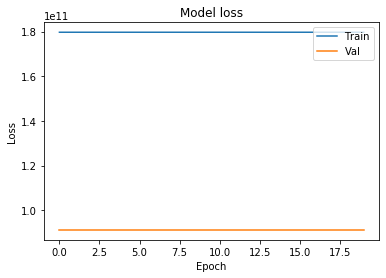

In [183]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(Train_x, Train_y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5)

model = Sequential([
    Dense(400, activation='relu', input_shape=(4,)),
    Dropout(0.2),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(20, activation='sigmoid'),
])

model.compile(loss="mean_squared_error", optimizer='sgd', metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=32, epochs=20,
          validation_data=(X_val, y_val))

model.evaluate(X_test, y_test)[1]

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [23]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)


(6820, 5) (852, 5) (853, 5) (6820, 1) (852, 1) (853, 1)


In [156]:
dfTrain.corr()

,house_type,price,year,living_space,city
house_type,1.000000,-0.008938,-0.197969,-0.016395,0.054078
price,-0.008938,1.000000,0.018126,0.034233,-0.012206
year,-0.197969,0.018126,1.000000,-0.029098,-0.031563
living_space,-0.016395,0.034233,-0.029098,1.000000,-0.023143
city,0.054078,-0.012206,-0.031563,-0.023143,1.000000


In [189]:
!git add "etuovi_scraper-all.py"

In [190]:
!git commit -m "data from all over Finland"

[master 86df6ab] data from all over Finland
 2 files changed, 9043 insertions(+)
 create mode 100644 etuovi_scraper-all.py
 create mode 100644 out2.json


## Toimeenpano

In [15]:
d={'Address': ["Lindforsinkatu 17"], 'City':["Tampere"]}
dist = pd.DataFrame(data=d)

dist['Address_geo'] = dist['Address'] + ", " + dist['City'] + ", Finland"

dist['Address_loc'] = dist['Address_geo'].apply(geolocator.geocode)
# select koordinates from loc
dist['Address_point'] = dist['Address_loc'].apply(lambda loc: tuple(loc.point) if loc else None)
#split coordinates to latitude, longitude and altitude
dist[['lat', 'lon', 'altitude']] = pd.DataFrame(dist['Address_point'].to_list(), index=df.index)

In [16]:
Distance = 10

In [17]:
import haversine as hs
from haversine import Unit
import folium
from folium.plugins import MarkerCluster

In [18]:
print(dist['lat'][0], dist['lon'][0])
print(df['lat'][0], df['lon'][0])

61.44706565 23.838184896329842
60.5508547 22.31609524144914


In [19]:
#Define coordinates of where we want to center our map
center = (dist['lat'][0], dist['lon'][0])

#Create the map
my_map = folium.Map(location = center, zoom_start = 10)

# Add addresses to the map
for index, row in df.iterrows():
    if hs.haversine(center,(row['lat'],row['lon']))<Distance:
        if row.point != None:
            text ="Price: " + str(row.price) + " €" + "\n Size: " + str(row['size']) + " m2 " + "Address: " + row.address
            folium.Marker([row.lat,row.lon], popup = text).add_to(my_map)

#Display the map
my_map


#To calculate distance in meters 
#hs.haversine(loc1,loc2,unit=Unit.METERS)

In [59]:
!git commit -m "Distance from the selected address added"

[master ba0cc17] Distance from the selected address added
 1 file changed, 158 insertions(+), 83 deletions(-)


In [60]:
!git pull

Removing Joda_oppimispaivakirja.ipynb
hint: Waiting for your editor to close the file... error: cannot run editor: No such file or directory
error: unable to start editor 'editor'
Not committing merge; use 'git commit' to complete the merge.


In [61]:
!git commit

hint: Waiting for your editor to close the file... error: cannot run editor: No such file or directory
error: unable to start editor 'editor'
Please supply the message using either -m or -F option.


In [20]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [25]:
#df.to_json(r'preprosessed_data.json')

In [ ]:

interact(f, Address=widgets.Combobox(options=["Chicago", "New York", "Washington"], value="Chicago"));
#alasvetovalikko
interact(f, City=['apples','oranges']);
#liukuvalikko
interact(f, x=(0,8,2));


In [24]:
@interact
def show_houses(Distance=(0,2000,10), City = 'Tampere', Address = 'Lindforsinkatu 17'):
    d={'Address': [Address], 'City':[City]}
    dist = pd.DataFrame(data=d)

    dist['Address_geo'] = dist['Address'] + ", " + dist['City'] + ", Finland"

    dist['Address_loc'] = dist['Address_geo'].apply(geolocator.geocode)
    # select koordinates from loc
    dist['Address_point'] = dist['Address_loc'].apply(lambda loc: tuple(loc.point) if loc else None)
    #split coordinates to latitude, longitude and altitude
    dist[['lat', 'lon', 'altitude']] = pd.DataFrame(dist['Address_point'].to_list(), index=df.index)
    
    center = (dist['lat'][0], dist['lon'][0])

    #Create the map
    my_map = folium.Map(location = center, zoom_start = 10)

    # Add addresses to the map
    for index, row in df.iterrows():
        if hs.haversine(center,(row['lat'],row['lon']))<Distance:
            if row.point != None:
                text ="Price: " + str(row.price) + " €" + "\n Size: " + str(row['size']) + " m2 " + "Address: " + row.address
                folium.Marker([row.lat,row.lon], popup = text).add_to(my_map)
    
    return my_map

interactive(children=(IntSlider(value=1000, description='Distance', max=2000, step=10), Text(value='Tampere', …